In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px
import numpy as np
import json
import matplotlib.ticker as ticker
import plotly.graph_objects as go

deltasHeatMapDF = pd.read_csv('data/deltasHeatMapDF.csv',index_col=0)
budget = pd.read_csv('data/budget.csv',index_col=0)
projectCosts = pd.read_csv('data/projectCosts.csv',index_col=0)
costStatusHeatMapDF = pd.read_csv('data/costStatusHeatMapDF.csv',index_col=0)
projectSteps = pd.read_csv('data/projectSteps.csv',index_col=0)

# Q1 - Are Projects *Actually* Delayed?

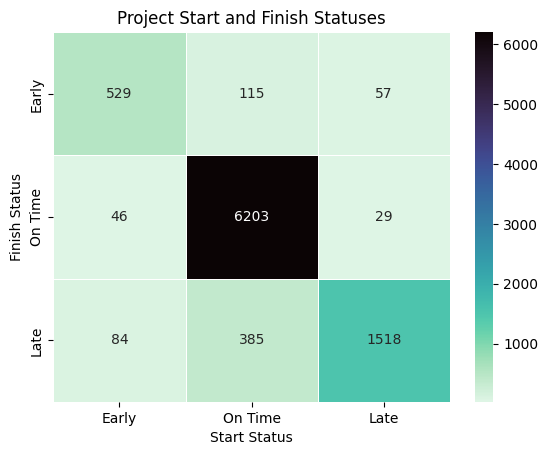

In [72]:
# Create a Heatmap of Project Start and Finish Statuses
sns.heatmap(deltasHeatMapDF,
            annot=True,
            fmt="d",
            linewidths=.5,
            cmap="mako_r");
plt.xlabel('Start Status');
plt.ylabel('Finish Status');
plt.title('Project Start and Finish Statuses');

plt.savefig('plots/Project_Start_Finish_heatmap.png', dpi=300, bbox_inches='tight')

## Where are projects delayed?

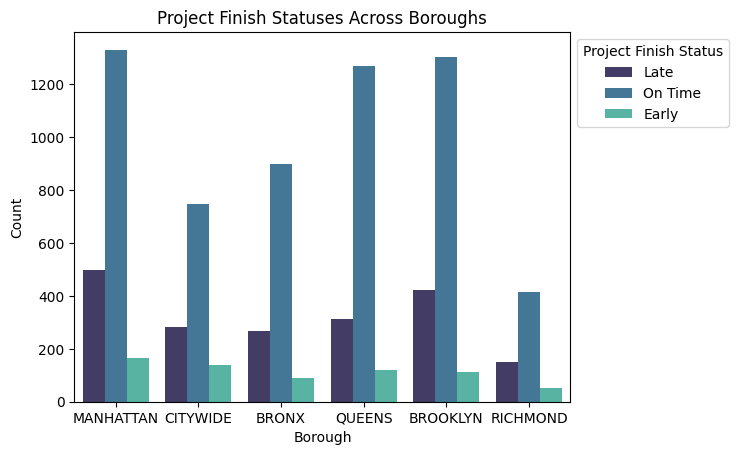

In [108]:
# Make a bar plot that shows the project finish status by boro
sns.countplot(x="boro", 
              hue="endStatus", 
              data=projectCosts,
              palette="mako");
plt.xlabel('Borough');
plt.ylabel('Count');
plt.title('Project Finish Statuses Across Boroughs');
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Project Finish Status')

plt.savefig('plots/Project_Finish_Statuses_by_Boro.png', dpi=300, bbox_inches='tight')

### Reasons why projects are delayed

In [29]:
# Make JSON file for blog post table of project delay description counts
budget['delay_desc'].str.title().value_counts().to_frame() \
        .reset_index().rename(columns={"index":"Delay Description","delay_desc":"Count"})\
        .to_json(path_or_buf='data/delayTable.json',orient='records') 

# Q2 - Budget Things

### Budget Status by Borough

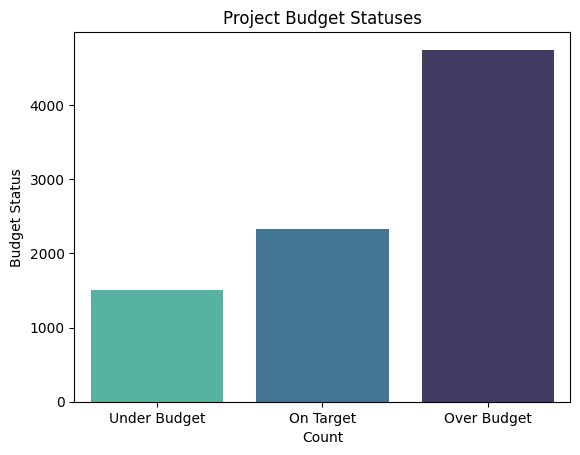

In [125]:
# make a bar plot of the number of projects that were over budget, on budget, and under budget
sns.countplot(x="costStatus",
              data=projectCosts,
              order=["Under Budget","On Target","Over Budget"],
              palette="mako_r");
plt.xlabel('Count');
plt.ylabel('Budget Status');
plt.title('Project Budget Statuses');

plt.savefig('plots/Project_Budget_Status_bar.png', dpi=300, bbox_inches='tight')


In [126]:
# Make JSON file for blog post table of managing agency project counts
projectCosts['managing_agcy'].value_counts().to_frame() \
        .reset_index().rename(columns={"index":"Managing Agency","managing_agcy":"Count"})\
        .to_json(path_or_buf='data/agencyTable.json',orient='records')

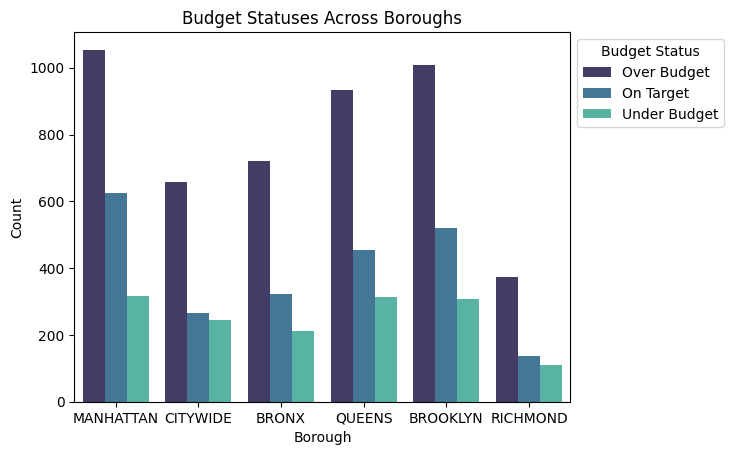

In [122]:
# Make a bar plot that shows the number of projects that were over/under budget by boro
sns.countplot(x="boro", 
              hue="costStatus", 
              data=projectCosts,
              palette="mako");
plt.xlabel('Borough');
plt.ylabel('Count');
plt.title('Budget Statuses Across Boroughs');
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Budget Status')

plt.savefig('plots/Project_Budget_Status_boro_bar.png', dpi=300, bbox_inches='tight')

### Budget Status by Project Finish Status

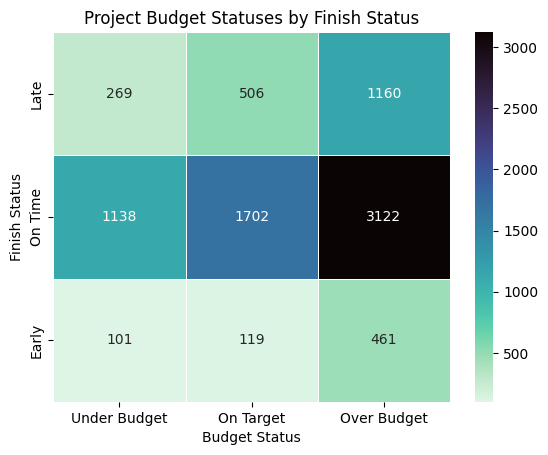

In [129]:
sns.heatmap(costStatusHeatMapDF,
            annot=True,
            fmt="d",
            linewidths=.5,
            cmap="mako_r");
plt.xlabel("Budget Status")
plt.ylabel("Finish Status")
plt.title("Project Budget Statuses by Finish Status");
plt.savefig('plots/Budget_Status_Late_Projects_heatmap.png', dpi=300, bbox_inches='tight')

### Budget Deltas by Agencies

In [47]:
# What is the average cost delta for projects by managing agnecy?
agencyBudgets = projectCosts.groupby('managing_agcy')[['managing_agcy','cost_delta']] \
                    .agg({ 'cost_delta': 'mean'}) \
                    .astype({'cost_delta': 'int64'}) \
                    .sort_values('cost_delta', ascending=False).reset_index()

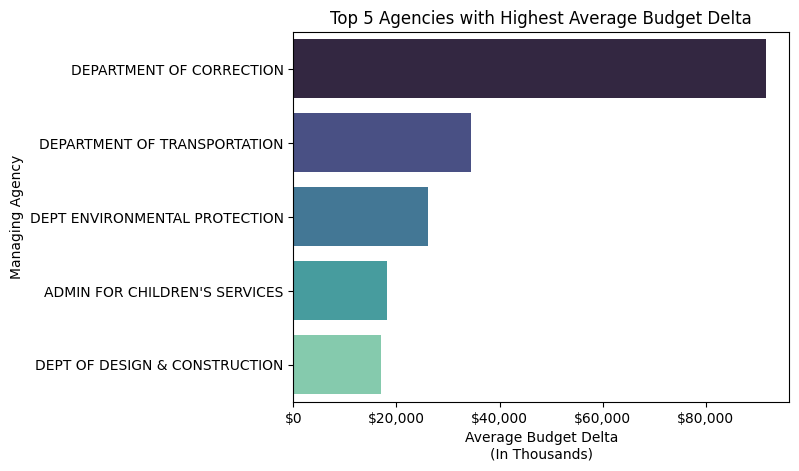

In [48]:
# Plot the top 5 agencies with the highest average cost delta
sns.barplot(y="managing_agcy",
            x="cost_delta",
            data=agencyBudgets.head(),
            order=agencyBudgets['managing_agcy'].head(),
            palette="mako");
plt.xlabel('Average Budget Delta\n(In Thousands)');
plt.ylabel('Managing Agency');
plt.title('Top 5 Agencies with Highest Average Budget Delta');

# Format x-axis tick labels with a dollar sign
formatter = ticker.FuncFormatter(lambda x, _: '${:,.0f}'.format(x))   # Format labels as $value
plt.gca().xaxis.set_major_formatter(formatter)
plt.savefig('plots/Top_5_Agencies_Highest_Average_Budget_Delta.png', dpi=300, bbox_inches='tight')

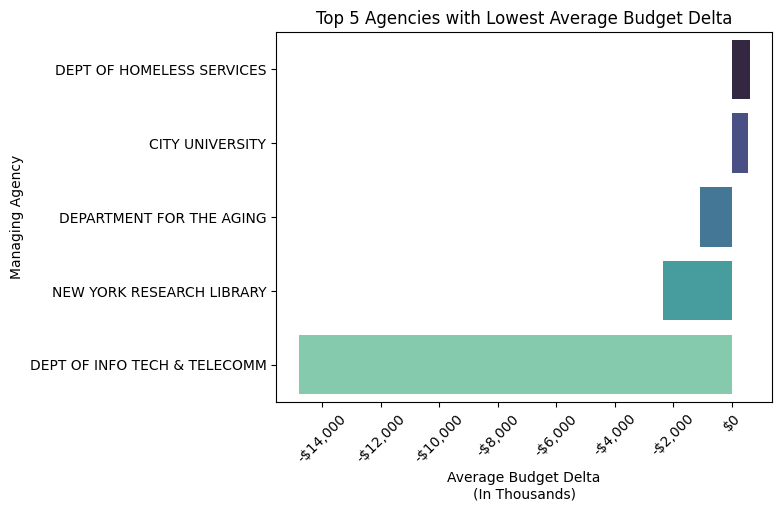

In [49]:
# Make a bar plot of the top 5 agencies with the lowest average cost delta
sns.barplot(y="managing_agcy",
            x="cost_delta",
            data=agencyBudgets.tail(),
            order=agencyBudgets['managing_agcy'].tail(),
            palette="mako");
plt.xlabel('Average Budget Delta\n(In Thousands)');
plt.ylabel('Managing Agency');
plt.title('Top 5 Agencies with Lowest Average Budget Delta');


# Format x-axis tick labels with appropriate commas and dollar sign, placing negative sign before the dollar sign
def x_currency_formatter(x, pos):
    if x < 0:
        return f'-${abs(x):,.0f}'  # If negative, place the negative sign before the dollar sign
    else:
        return f'${x:,.0f}'
formatter = ticker.FuncFormatter(x_currency_formatter)
plt.gca().xaxis.set_major_formatter(formatter);

# Rotate x-axis tick labels by 45 degrees
plt.xticks(rotation=45);
plt.savefig('plots/Top_5_Agencies_Lowest_Budget_Delta_bar.png', dpi=300, bbox_inches='tight')

### Who paid more for late projects?

In [34]:
# There are some projects with an initial budget of $0 Let's filter those out
cleanProjectCosts = projectCosts[projectCosts['orig_bud_amt'] != 0]

# what is the average cost delta for projects by 'funded by'?
avgBudgetDeltaByFunder_df = cleanProjectCosts.groupby('funded_by')[['funded_by','cost_delta']] \
        .agg({ 'cost_delta': 'mean'}) \
        .astype({'cost_delta': 'int64'}) \
        .sort_values('cost_delta', ascending=False).reset_index()\
        .rename(columns={"funded_by":"Funded By","cost_delta":"Average Budget Delta"})

# output to json file for blog post table
avgBudgetDeltaByFunder_df.to_json(path_or_buf='data/avgBudgetDeltaByFunder.json',orient='records') 

Funded By  Average Budget Delta
0      Both                 24321
1      City                  7558
2  Non City                 -1366

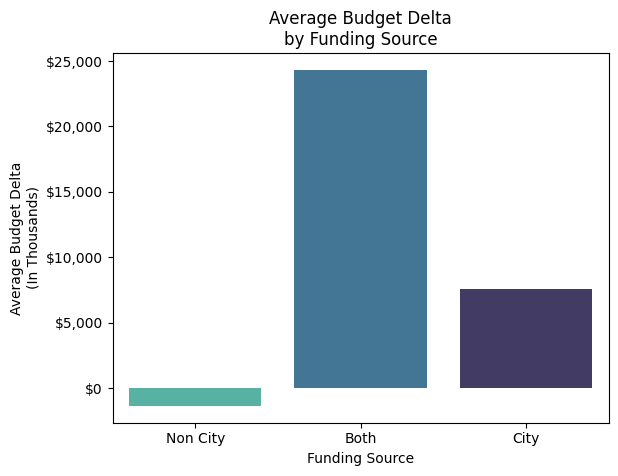

In [50]:
# avgBudgetDeltaByFunder_df
sns.barplot(x="Funded By",
            y="Average Budget Delta",
            data=avgBudgetDeltaByFunder_df,
            order = ['Non City','Both','City'],
            palette="mako_r");
plt.title('Average Budget Delta\nby Funding Source');

def y_currency_formatter(y, pos):
    if y < 0:
        return f'-${abs(y):,.0f}'  # If negative, place the negative sign before the dollar sign
    else:
        return f'${y:,.0f}'
formatter = ticker.FuncFormatter(y_currency_formatter)
plt.gca().yaxis.set_major_formatter(formatter);
plt.ylabel('Average Budget Delta\n(In Thousands)');
plt.xlabel('Funding Source');
plt.savefig('plots/BudgetDeltaByFundingSource.png', dpi=300, bbox_inches='tight')